# Capture and demodulate FM radio

* You need a RTLSDR USB dongle (https://osmocom.org/projects/rtl-sdr/wiki/Rtl-sdr)
* The library `librtlsdr`
* Julia 1.0 (or later) with some packages installable as:
```julia
using Pkg
Pkg.add("DSP")
Pkg.add("WAV")
Pkg.add("PyPlot")
Pkg.add("RTLSDR")
``` 

The code is tested in Linux.

Import the necessary packages

In [1]:
import DSP
using WAV
using PyPlot
using Test
using Statistics
using RTLSDR
using Dates

┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /home/abarth/.julia/compiled/v1.0/RTLSDR/ATj0M.ji for RTLSDR [71cfaeeb-f3e6-59e7-80b9-1b8c23d8f010]
└ @ Base loading.jl:1187


fm_deempth

In [7]:
data = read("/home/abarth/Downloads/FMcapture1043_3.dat");
#data = read("/home/abarth/Downloads/sample.rtl");
#data = read("/home/abarth/gqrx_20190820_195237_88458000_1800000_fc.raw");


In [6]:
# number of bytes in buffer
buffer_size = 1024*10*2
# sample rate
Fs = 1_140_000 # Hz

# frequency of the radio station
frequency_station = 88_500_000 # Hz

# offset frequency to avoid DC spike
frequency_offset = 250_000 # Hz


# center frequency for capture
freq = frequency_station - frequency_offset


88250000

Connect to the software-defined ratio, set the center frequency and the sampling rate and read several chunks of data.

In [152]:
#rf = RTLSDR.rtlsdr_open()


Found Rafael Micro R820T tuner


Ptr{RTLSDR.rtlsdr_dev} @0x000000000ebace60

In [248]:
rf = RTLSDR.rtlsdr_open()
RTLSDR.rtlsdr_reset_buffer(rf)
RTLSDR.rtlsdr_set_center_freq(rf, freq);
RTLSDR.rtlsdr_set_sample_rate(rf, Fs);
RTLSDR.rtlsdr_set_agc_mode(rf,1)
RTLSDR.rtlsdr_set_tuner_gain_mode(rf,0)

buffers = [RTLSDR.read_bytes(rf, buffer_size) for i in 1:1000];
RTLSDR.rtlsdr_close(rf)
rf = nothing

data = reduce(vcat,buffers);
extrema(Int.(data))

Found Rafael Micro R820T tuner
Exact sample rate is: 1140000.002265 Hz


(107, 148)

In [101]:
# read file as unsigned integers UInt
#write("FMcapture-samplerate-$(Fs)-offset-$(frequency_offset)-$(Dates.now()).raw",data)

20480000

In [2]:
data = read("FMcapture-samplerate-1140000-offset-250000-2019-08-21T21:36:25.223.raw")

20480000-element Array{UInt8,1}:
 0x70
 0xa3
 0x6d
 0x86
 0x6e
 0x69
 0x84
 0x56
 0x83
 0x90
 0x91
 0x79
 0x77
    ⋮
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f
 0x7f

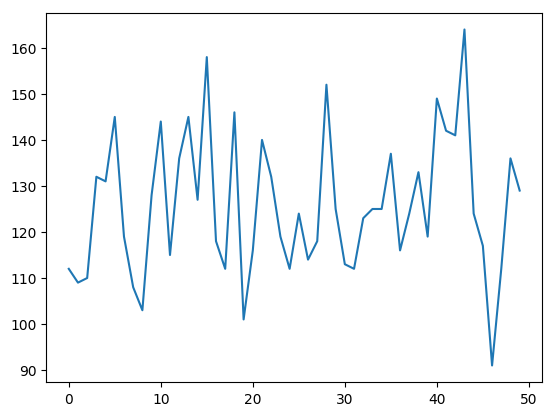

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2b7ea561d0>

In [3]:
plot(data[1:2:100])

In [4]:
y = complex.(data[1:2:end] .- 255/2,data[2:2:end] .- 255/2)

y_range = extrema(abs.(y))

# normalize
x1 = -1 .+ 2 * (y .- y_range[1])./(y_range[2] .- y_range[1]);
#x1 = y .- mean(y)
#x1 = y

Plot the spectogram of the normalized signal

In [5]:
specgram(x1, NFFT=1024, Fs=Fs)
title("Spectogram of signal post normalization")
xlabel("Time")
ylabel("Frequency");

UndefVarError: UndefVarError: Fs not defined

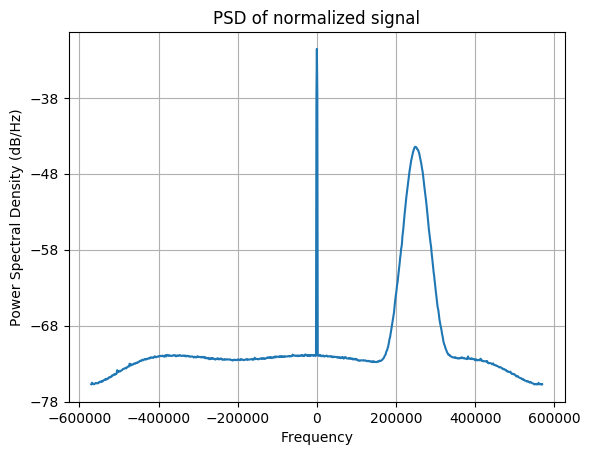

In [255]:
psd(x1, NFFT=1024, Fs=Fs)
title("PSD of normalized signal");

In [256]:
#scatter(real(x1[1:Fs]), imag(x1[1:Fs]))
#title("Constellation of the 'signal' loaded from file")
#

Comensate for the frequency offset

In [257]:
## Mixer Processing
Fs = 1_140_000
fc = exp.(-2im * π * frequency_offset/Fs * (0:length(x1)-1))
x2 = x1 .* fc;

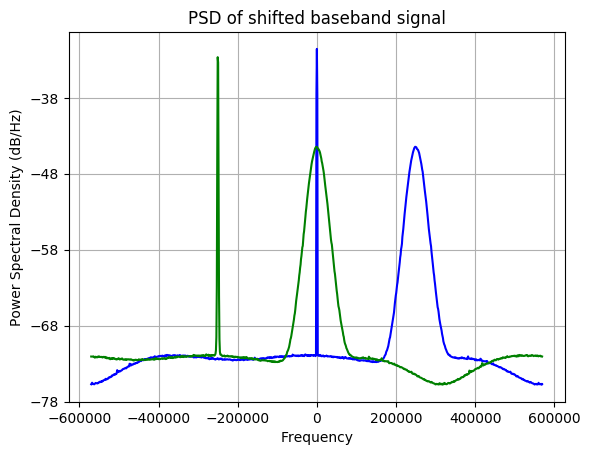

In [258]:
psd(x1, NFFT=1024, Fs=Fs, color = "blue")
psd(x2, NFFT=1024, Fs=Fs, color = "green")
title("PSD of shifted baseband signal");

In [259]:
## Filter Operations
f_bw = 200_000
Fs = Fs
n_taps = 64

lpf = DSP.remez(n_taps, [ (0., f_bw) => 1,
                          (f_bw+(Fs/2-f_bw)/4, Fs/2) => 0],
                Hz=Fs)

filter = DSP.PolynomialRatio(lpf,[1.]);

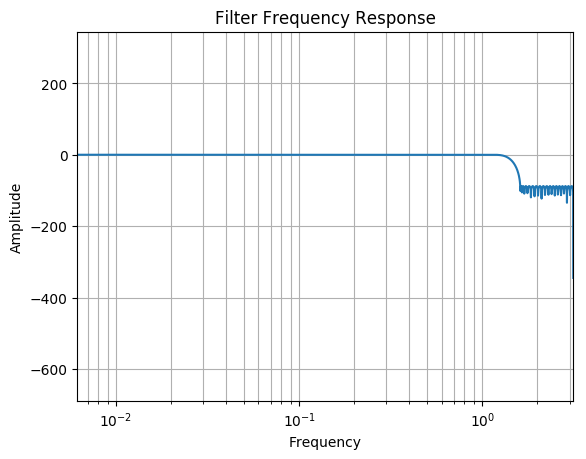

In [260]:
w = range(0,stop=π,length=512)
h = DSP.freqz(filter, w)
plot(w, 20*log10.(abs.(h)))
xscale("log")
title("Filter Frequency Response")
xlabel("Frequency")
ylabel("Amplitude")
margins(0,1)
grid(which="both",axis="both");



In [261]:
x3 = DSP.filt(filter,x2);

A filter is just a convolution:

In [262]:
@test sum(x2[1:64] .* lpf) ≈ x3[64]
@test sum(x2[2:65] .* lpf) ≈ x3[65]

Test Passed

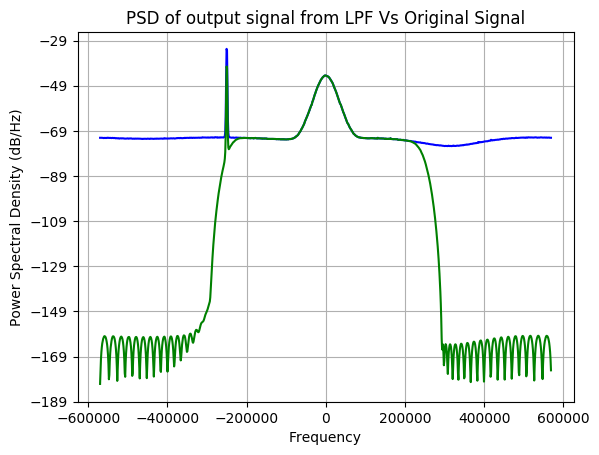

In [263]:
psd(x2, NFFT=1024, Fs=Fs, color="blue")  # original
psd(x3, NFFT=1024, Fs=Fs, color="green")  # filtered
title("PSD of output signal from LPF Vs Original Signal");


Decimate the Signal

In [264]:
dec_rate = Fs ÷ f_bw
x4 = DSP.resample(x3, 1//dec_rate)
Fs_x4 = Fs/dec_rate

228000.0

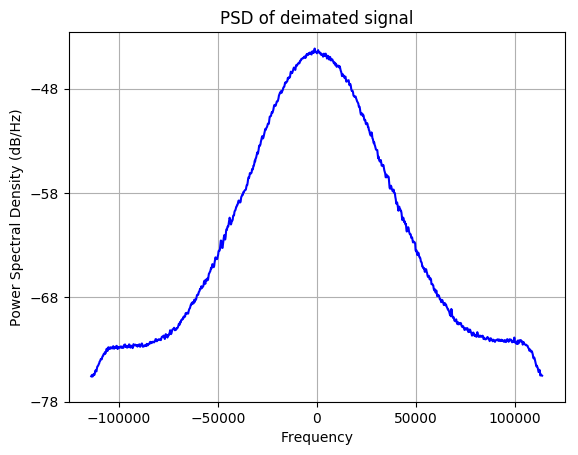

In [265]:
psd(x4, NFFT=1024, Fs=Fs_x4, color="blue")
title("PSD of decimated signal");


Frequency Discriminator

In [ ]:
# https://web.archive.org/web/20190819144410/https://www.gnuradio.org/doc/doxygen/classgr_1_1analog_1_1quadrature__demod__cf.html
# https://dsp.stackexchange.com/a/49005
function quadrature_demod(z)
    y = z[2:end] .* conj.(z[1:end-1])
    return angle.(y)
end


In [266]:
x5 = quadrature_demod(x4);

![FMspectrum](https://upload.wikimedia.org/wikipedia/commons/c/cd/RDS_vs_DirectBand_FM-spectrum2.svg)

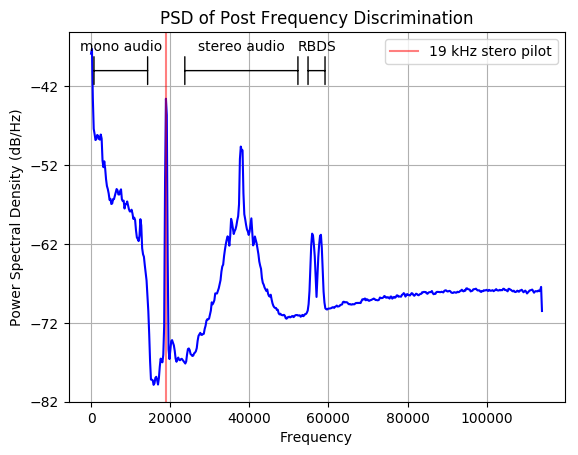

In [268]:
psd(x5, NFFT=1024, Fs=Fs_x4, color="blue")
title("PSD of Post Frequency Discrimination");
ylim()
axvline(x=19e3, color="red", alpha=0.5,label="19 kHz stero pilot")
#axvline(x=92e3, color="yellow", alpha=0.5,label="Audos")

function annotaterange(Fmin,Fmax,text)
annotate(text, xy=((Fmin+Fmax)/2,-37),  ha="center", va="center" )
annotate("", xy=(Fmin, -40), xytext=(Fmax, -40), xycoords="data", textcoords="data",
            arrowprops=Dict("arrowstyle" => "|-|"))
end
#annotate("stereo audio", xy=(27e3,-37),  ha="left", va="center" )
#annotate("", xy=(23e3, -38), xytext=(53e3, -38), xycoords="data", textcoords="data",
#            arrowprops=Dict("arrowstyle" => "|-|"))

annotaterange(30,15e3,"mono audio")
annotaterange(23e3,53e3,"stereo audio")
#annotaterange(58.65e3,76.65e3,"direct band")
annotaterange(57e3 * 0.95,57e3 * 1.05,"RBDS")

legend();

In [ ]:

"""
FM Deemphasis Filter
https://de.wikipedia.org/wiki/Pre-Emphasis
τ = 75 µs in North America
τ = 50 µs in Europe
"""
function fm_deempth(z,Fs,τ)
    d = Fs * τ       # Calculate the # of samples to hit the -3dB point
    r = exp.(-1/d)   # Calculate the decay between each sample
    # Create the filter coefficients
    b = [1-r]
    a = [1,-r]

    return DSP.filt(b,a,z)
end

In [269]:
## De Emphasis Filter
# https://de.wikipedia.org/wiki/Pre-Emphasis
# 75 µs in North America
# 50 µs in Europe
#τ = 75e-6
τ = 50e-6

x6 = fm_deempth(x5,Fs_x4,τ);
#x6 = x5

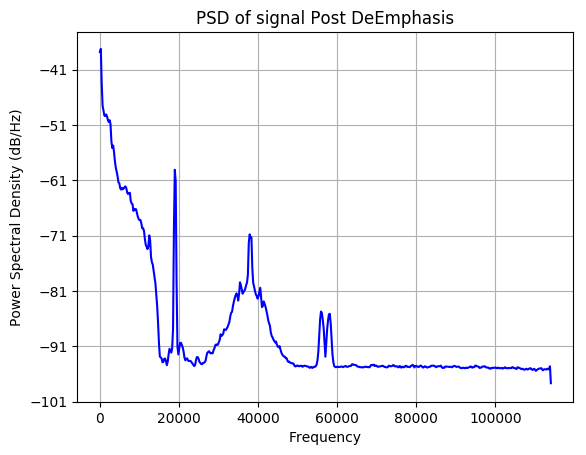

In [270]:
psd(x6, NFFT=1024, Fs=Fs_x4, color="blue")
title("PSD of signal Post DeEmphasis");


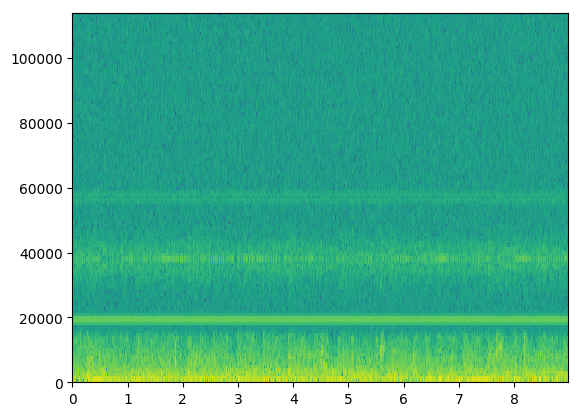

In [282]:
specgram(x6, Fs=Fs_x4);


In [271]:
@show Fs_x4, dec_rate, Fs_x4/dec_rate

(Fs_x4, dec_rate, Fs_x4 / dec_rate) = (228000.0, 5, 45600.0)


(228000.0, 5, 45600.0)

In [278]:
## Decimating Output of De Emphasis Filter
x7 = DSP.resample(x6, 1//dec_rate);
Fs_x7 = Fs_x4/dec_rate

45600.0

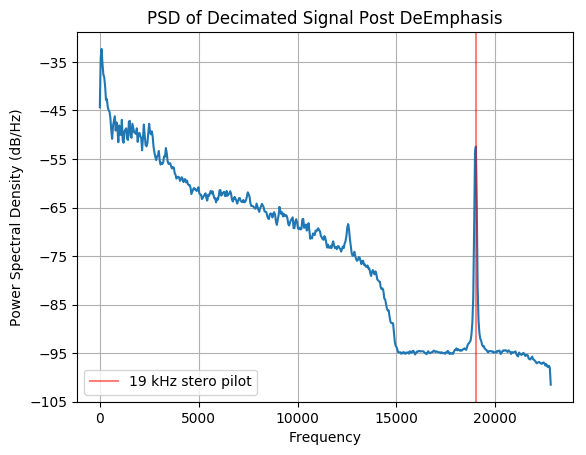

PyObject <matplotlib.legend.Legend object at 0x7f7958200ef0>

In [279]:
psd(x7, NFFT=1024, Fs=Fs_x7)
axvline(x=19e3, color="red", alpha=0.5,label="19 kHz stero pilot")
title("PSD of Decimated Signal Post DeEmphasis");
legend()

In [274]:
## Write Data To AudioFile
x7 *= 10000 / maximum(abs.(x7));               # scale so it's audible

In [275]:
wavwrite(round.(Int16,x7), "test.wav", Fs=44100);

In [276]:
WAVArray(44100,round.(Int16,x7))

WAVArray{Int16,1}(44100, Int16[-11, -3389, -5330, 490, 3701, 3418, 4582, 7626, 8142, 10000  …  74, -305, 26, 274, 782, 525, 300, -23, -279, -112])

# Credits

Many thanks to Ajinkya Kadam who provided a [python FM decomulator](https://web.archive.org/web/20190819133107/https://ajinkyakadam.bitbucket.io/blogpost/2015/09/17/fmdemod/) using the instruction from http://witestlab.poly.edu/~ffund/el9043/labs/lab1.html.

